## Import all library

In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
import mne
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pywt 
from PIL import Image
from utility import *
from model import *
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, precision_recall_curve


LOSS_POS_WEIGHT       = torch.tensor([1])

MODEL_FILE_DIRC_SateLight     = MODEL_FILE_DIRC + "/SateLight"
MODEL_FILE_DIRC_SateLight_syn = MODEL_FILE_DIRC + "/SateLight_synthesized"
MODEL_FILE_DIRC_CNN           = MODEL_FILE_DIRC + "/CNN"
MODEL_FILE_DIRC_CNN_syn       = MODEL_FILE_DIRC + "/CNN_synthesized"

torch.manual_seed(3407)

## Data Preparation
* Convert the data from csv to Dataloader

In [2]:
%%time
eeg_num_list = list(range(1,98))

dataloaders, num_data = get_dataloader(eeg_num_list, shuffle=True, get_dataDWT=False)
    

num_train_data, num_valid_data, num_test_data = num_data
train_data, valid_data, test_data             = dataloaders

The data from EEG_csv/eeg1.csv is loaded 
There is no spike in this eeg file
(6, 1280, 19)
EEG1 has 6 windows of data 


The data from EEG_csv/eeg2.csv is loaded 
There is no spike in this eeg file
(9, 1280, 19)
EEG2 has 9 windows of data 


The data from EEG_csv/eeg3.csv is loaded 
There is no spike in this eeg file
(77, 1280, 19)
EEG3 has 77 windows of data 


The data from EEG_csv/eeg4.csv is loaded 
There is no spike in this eeg file
(2, 1280, 19)
EEG4 has 2 windows of data 


The data from EEG_csv/eeg5.csv is loaded 
There is spike in this eeg file
Data before split : (3840, 19)
Data with   spike: (3840, 19)
Data after  split into window: (3, 1280, 19)
Labels: (3,)
Num spike: 3
EEG5 has 3 windows of data 




The data from EEG_csv/eeg6.csv is loaded 
There is no spike in this eeg file
(207, 1280, 19)
EEG6 has 207 windows of data 


The data from EEG_csv/eeg7.csv is loaded 
There is spike in this eeg file
Data before split : (215040, 19)
Data with   spike: (215040, 19)
Data after  split into window: (168, 1280, 19)
Labels: (168,)
Num spike: 168
EEG7 has 168 windows of data 


The data from EEG_csv/eeg8.csv is loaded 
There is no spike in this eeg file
(1, 1280, 19)
EEG8 has 1 windows of data 


The data from EEG_csv/eeg9.csv is loaded 
There is no spike in this eeg file
(96, 1280, 19)
EEG9 has 96 windows of data 


The data from EEG_csv/eeg10.csv is loaded 
There is no spike in this eeg file
(260, 1280, 19)
EEG10 has 260 windows of data 


The data from EEG_csv/eeg11.csv is loaded 
There is no spike in this eeg file
(6, 1280, 19)
EEG11 has 6 windows of data 


The data from EEG_csv/eeg12.csv is loaded 
There is no spike in this eeg file
(21, 1280, 19)
EEG12 has 21 windows of data 


The data

## Plot ROC AUC on validation and testing dataset

In [3]:
def evaluate_classifier_probs(model, dataloader, device,):
    list_pred_label = []
    list_corr_label = []
    
    for epoch_data, label in dataloader:
        epoch_data = epoch_data.to(device)
        label      = label[:,None].to(device).float()
        
        output     = model(epoch_data)
        
        list_pred_label.extend(torch.sigmoid(output.cpu().detach()).numpy().flatten().tolist())
        list_corr_label.extend(label.cpu().flatten().tolist())

    return list_corr_label, list_pred_label  

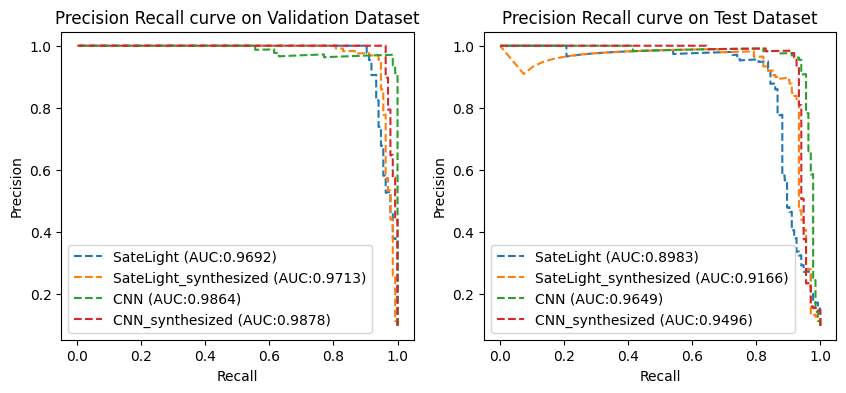

In [11]:
MODEL_FILE_DIRC_SateLight     = MODEL_FILE_DIRC + "/SateLight"
MODEL_FILE_DIRC_SateLight_syn = MODEL_FILE_DIRC + "/SateLight_synthesized"
MODEL_FILE_DIRC_CNN           = MODEL_FILE_DIRC + "/CNN"
MODEL_FILE_DIRC_CNN_syn       = MODEL_FILE_DIRC + "/CNN_synthesized"


fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, (dataloader, dataset_type) in enumerate(zip([valid_data, test_data], 
                                                 ["Validation Dataset", "Test Dataset"])):

    for model_path, model_type in zip([MODEL_FILE_DIRC_SateLight, MODEL_FILE_DIRC_SateLight_syn, MODEL_FILE_DIRC_CNN, MODEL_FILE_DIRC_CNN_syn], 
                                    ["SateLight", "SateLight", "CNN", "CNN"]):
        if model_type == "SateLight":
            model = SateLight().to(device)
        else:
            model = CNN().to(device)
        
        # Load the best trained model
        model.eval()
        state_dict_loaded = torch.load(f"{model_path}/{model_type}_best.pt")
        model.load_state_dict(state_dict_loaded["model"])
        
        # Get the probability output from model
        labels, pred_probs = evaluate_classifier_probs(model, dataloader, device)
        
        # Plot the AUC 
        precision, recall, thresholds = precision_recall_curve(labels, pred_probs, pos_label=1)
        auc_ = auc(recall, precision)

        
        ax[i].plot(recall, precision, linestyle='--', label=f"{model_path.split('/')[-1]} (AUC:{auc_:.4f})")
        ax[i].set_title(f'Precision Recall curve on {dataset_type}')
        ax[i].set_xlabel('Recall')
        ax[i].set_ylabel('Precision')
        ax[i].legend(loc='best')
        
plt.show()

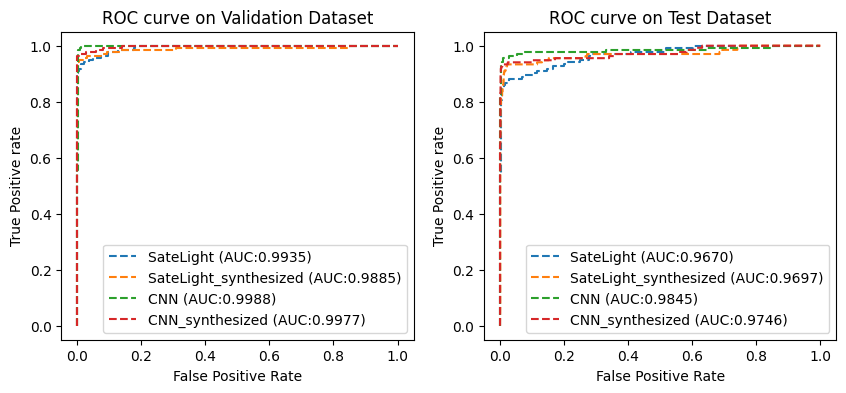

In [12]:
MODEL_FILE_DIRC_SateLight     = MODEL_FILE_DIRC + "/SateLight"
MODEL_FILE_DIRC_SateLight_syn = MODEL_FILE_DIRC + "/SateLight_synthesized"
MODEL_FILE_DIRC_CNN           = MODEL_FILE_DIRC + "/CNN"
MODEL_FILE_DIRC_CNN_syn       = MODEL_FILE_DIRC + "/CNN_synthesized"


fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, (dataloader, dataset_type) in enumerate(zip([valid_data, test_data], 
                                                 ["Validation Dataset", "Test Dataset"])):

    for model_path, model_type in zip([MODEL_FILE_DIRC_SateLight, MODEL_FILE_DIRC_SateLight_syn, MODEL_FILE_DIRC_CNN, MODEL_FILE_DIRC_CNN_syn], 
                                    ["SateLight", "SateLight", "CNN", "CNN"]):
        if model_type == "SateLight":
            model = SateLight().to(device)
        else:
            model = CNN().to(device)
        
        # Load the best trained model
        model.eval()
        state_dict_loaded = torch.load(f"{model_path}/{model_type}_best.pt")
        model.load_state_dict(state_dict_loaded["model"])
        
        # Get the probability output from model
        labels, pred_probs = evaluate_classifier_probs(model, dataloader, device)
        
        # Plot the AUC 
        fpr, tpr, thresholds = roc_curve(labels, pred_probs, pos_label=1)
        roc_auc = auc(fpr, tpr)

        
        ax[i].plot(fpr, tpr, linestyle='--', label=f"{model_path.split('/')[-1]} (AUC:{roc_auc:.4f})")
        ax[i].set_title(f'ROC curve on {dataset_type}')
        ax[i].set_xlabel('False Positive Rate')
        ax[i].set_ylabel('True Positive rate')
        ax[i].legend(loc='best')
        
plt.show()

In [6]:
MODEL_FILE_DIRC_SateLight     = MODEL_FILE_DIRC + "/SateLight"
MODEL_FILE_DIRC_SateLight_syn = MODEL_FILE_DIRC + "/SateLight_synthesized"
MODEL_FILE_DIRC_CNN           = MODEL_FILE_DIRC + "/CNN"
MODEL_FILE_DIRC_CNN_syn       = MODEL_FILE_DIRC + "/CNN_synthesized"
threshold_list                = [0.5, 0.5, 0.5, 0.5]

list_valid_metrics, list_test_metrics  = [], []
for i, (dataloader, dataset_type) in enumerate(zip([valid_data, test_data], 
                                                 ["Validation Dataset", "Test Dataset"])):

    for model_path, model_type, threshold in zip([MODEL_FILE_DIRC_SateLight, MODEL_FILE_DIRC_SateLight_syn, MODEL_FILE_DIRC_CNN, MODEL_FILE_DIRC_CNN_syn], 
                                                 ["SateLight", "SateLight", "CNN", "CNN"], 
                                                 threshold_list):
        if model_type == "SateLight":
            model = SateLight().to(device)
        else:
            model = CNN().to(device)
        
        # Load the best trained model
        model.eval()
        state_dict_loaded = torch.load(f"{model_path}/{model_type}_best.pt")
        model.load_state_dict(state_dict_loaded["model"])
        
        # Get the probability output from model
        labels, pred_probs = evaluate_classifier_probs(model, dataloader, device)
        
        # Get the result using a certain threshold
        pred_labels = np.array(np.round(pred_probs, decimals=6)) > threshold
        
        accuracy = accuracy_score(labels, pred_labels)
        f1       = f1_score(labels, pred_labels)
        
        if dataset_type == "Validation Dataset":
            list_valid_metrics.append([accuracy, f1])
        elif dataset_type == "Test Dataset":
            list_test_metrics.append([accuracy, f1])

threshold_list     = np.array(threshold_list)[:,None] # Reshape to (n, 1)
list_valid_metrics = np.array(list_valid_metrics)     # Shape = (n, 2)
list_test_metrics  = np.array(list_test_metrics)      # Shape = (n, 2)
list_metrics       = np.concatenate([threshold_list, list_valid_metrics, list_test_metrics], axis=1)

In [7]:
df = pd.DataFrame(list_metrics, columns=["Threshold used","Validation Accuracy", "Validation f1-score", 
                                         "Test Accuracy", "Test f1-score"],
                                index=["SateLight", "SateLight_synthesized", "CNN", "CNN_synthesized"])
df

,Threshold used,Validation Accuracy,Validation f1-score,Test Accuracy,Test f1-score
SateLight,0.5,0.989788,0.945736,0.976659,0.870968
SateLight_synthesized,0.5,0.990518,0.951311,0.978118,0.888060
CNN,0.5,0.994894,0.974170,0.987600,0.934363
CNN_synthesized,0.5,0.996353,0.981132,0.989059,0.942966
